# Decision Trees and Random Forests - Machine Learning with Python

This tutorial is a part of [Zero to Data Science Bootcamp by Jovian](https://zerotodatascience.com) and [Machine Learning with Python: Zero to GBMs](https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms)

![](https://i.imgur.com/N8aIuRK.jpg)

# 🌳 Decision Tree
A Decision Tree is a flowchart-like model that makes decisions by asking a series of questions about the data.


# 🌲🌲 Random Forest

A Random Forest is just:
        A bunch of decision trees voting together


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
raw_df = pd.read_csv("weatherAUS.csv")

In [3]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True) # this drop the values of raintomorrow where values are null

In [4]:
year= pd.to_datetime(raw_df.Date).dt.year

In [5]:
train_df = raw_df[year < 2015]
val_df   = raw_df[year == 2015]
test_df  = raw_df[year > 2015]

In [6]:
input_cols = list(train_df.columns)[1:-1]
target_cols = ["RainTomorrow"]

In [7]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_cols].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_cols].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_cols].copy()

In [8]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

C:\Users\zisha\AppData\Local\Temp\ipykernel_14856\2397943287.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = train_inputs.select_dtypes('object').columns.tolist()


In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])
test_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [12]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [13]:
val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


In [14]:
from sklearn.preprocessing import OneHotEncoder

In [15]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [16]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [17]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

C:\Users\zisha\AppData\Local\Temp\ipykernel_14856\1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\zisha\AppData\Local\Temp\ipykernel_14856\1584174743.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
C:\Users\zisha\AppData\Local\Temp\ipykernel_14856\1584174743.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

In [18]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

# Training 

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
model = DecisionTreeClassifier(random_state = 42)

In [21]:
%%time 
model.fit(X_train,train_targets)

CPU times: total: 5.31 s
Wall time: 5.8 s


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

# Evaluation

# Prediction on Train dataSet

In [22]:
 train_preds = model.predict(X_train)

In [23]:
from sklearn.metrics import accuracy_score , confusion_matrix

In [24]:
pd.Series(train_preds).value_counts()

No     76707
Yes    22281
Name: count, dtype: int64

In [25]:
train_probs = model.predict_proba(X_train)

In [26]:
(accuracy_score(train_preds,train_targets))

0.9999797955307714

# Prediction on Validation set

In [27]:
val_preds = model.predict(X_val)

In [28]:
accuracy_score(val_preds,val_targets)

0.7921188555510418

# Prediction on Test dataSet

In [29]:
test_preds = model.predict(X_test)

In [30]:
accuracy_score(test_preds,test_targets)

0.7741202741202741

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

# Visualisation

In [31]:
from sklearn.tree import plot_tree, export_text

In [32]:
plt.figure(figsize=(80,20))

<Figure size 8000x2000 with 0 Axes>

<Figure size 8000x2000 with 0 Axes>

[Text(0.5, 0.875, 'Humidity3pm <= 0.715\ngini = 0.349\nsamples = 98988\nvalue = [76705, 22283]'),
 Text(0.25, 0.625, 'Rainfall <= 0.004\ngini = 0.248\nsamples = 82418\nvalue = [70439.0, 11979.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Sunshine <= 0.525\ngini = 0.198\nsamples = 69252\nvalue = [61538.0, 7714.0]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Humidity3pm <= 0.512\ngini = 0.438\nsamples = 13166\nvalue = [8901, 4265]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Humidity3pm <= 0.825\ngini = 0.47\nsamples = 16570\nvalue = [6266, 10304]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'WindGustSpeed <= 0.279\ngini = 0.499\nsamples = 9136\nvalue = [4804, 4332]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Rainfall <= 0.01\ngini = 0.316\nsamples = 7434\nvalue = [1462, 5972]'),
 Text(0.8125, 0.125,

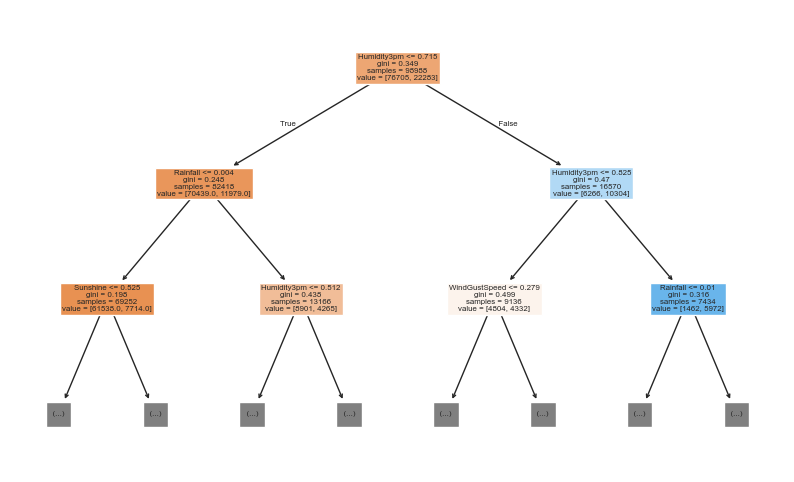

In [33]:
plot_tree(model,feature_names=X_train.columns,max_depth=2,filled=True)

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

In [34]:
model.tree_.max_depth

48

In [37]:
model.tree_.node_count

22227

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [43]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [45]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [46]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.261441
11,Pressure3pm,0.062057
2,Rainfall,0.059139
5,WindGustSpeed,0.056333
4,Sunshine,0.049465
8,Humidity9am,0.040218
14,Temp9am,0.035000
0,MinTemp,0.034894
10,Pressure9am,0.034415
1,MaxTemp,0.032361


C:\Users\zisha\AppData\Local\Temp\ipykernel_14856\4051305894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='importance', y='feature',palette="tab10");


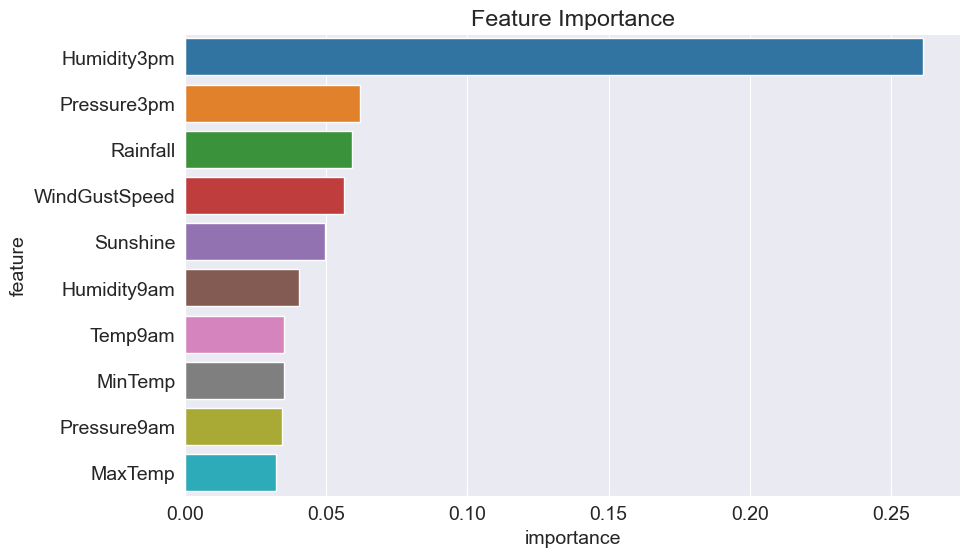

In [48]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature',palette="tab10");

In [49]:
model.score(X_train, train_targets)

0.9999797955307714

In [50]:
model.score(X_val, val_targets)

0.7921188555510418

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting.

The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

The Process of reducing overfitting is known as `regularlization`

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [83]:
model = DecisionTreeClassifier(max_depth=7,random_state=42)

In [84]:
model.fit(X_train,train_targets)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

In [85]:
model.score(X_train,train_targets)

0.8466884874934335

In [86]:
model.score(X_val,val_targets) 

0.8453949277465034

In [87]:
model.score(X_test,test_targets)

0.8310618310618311

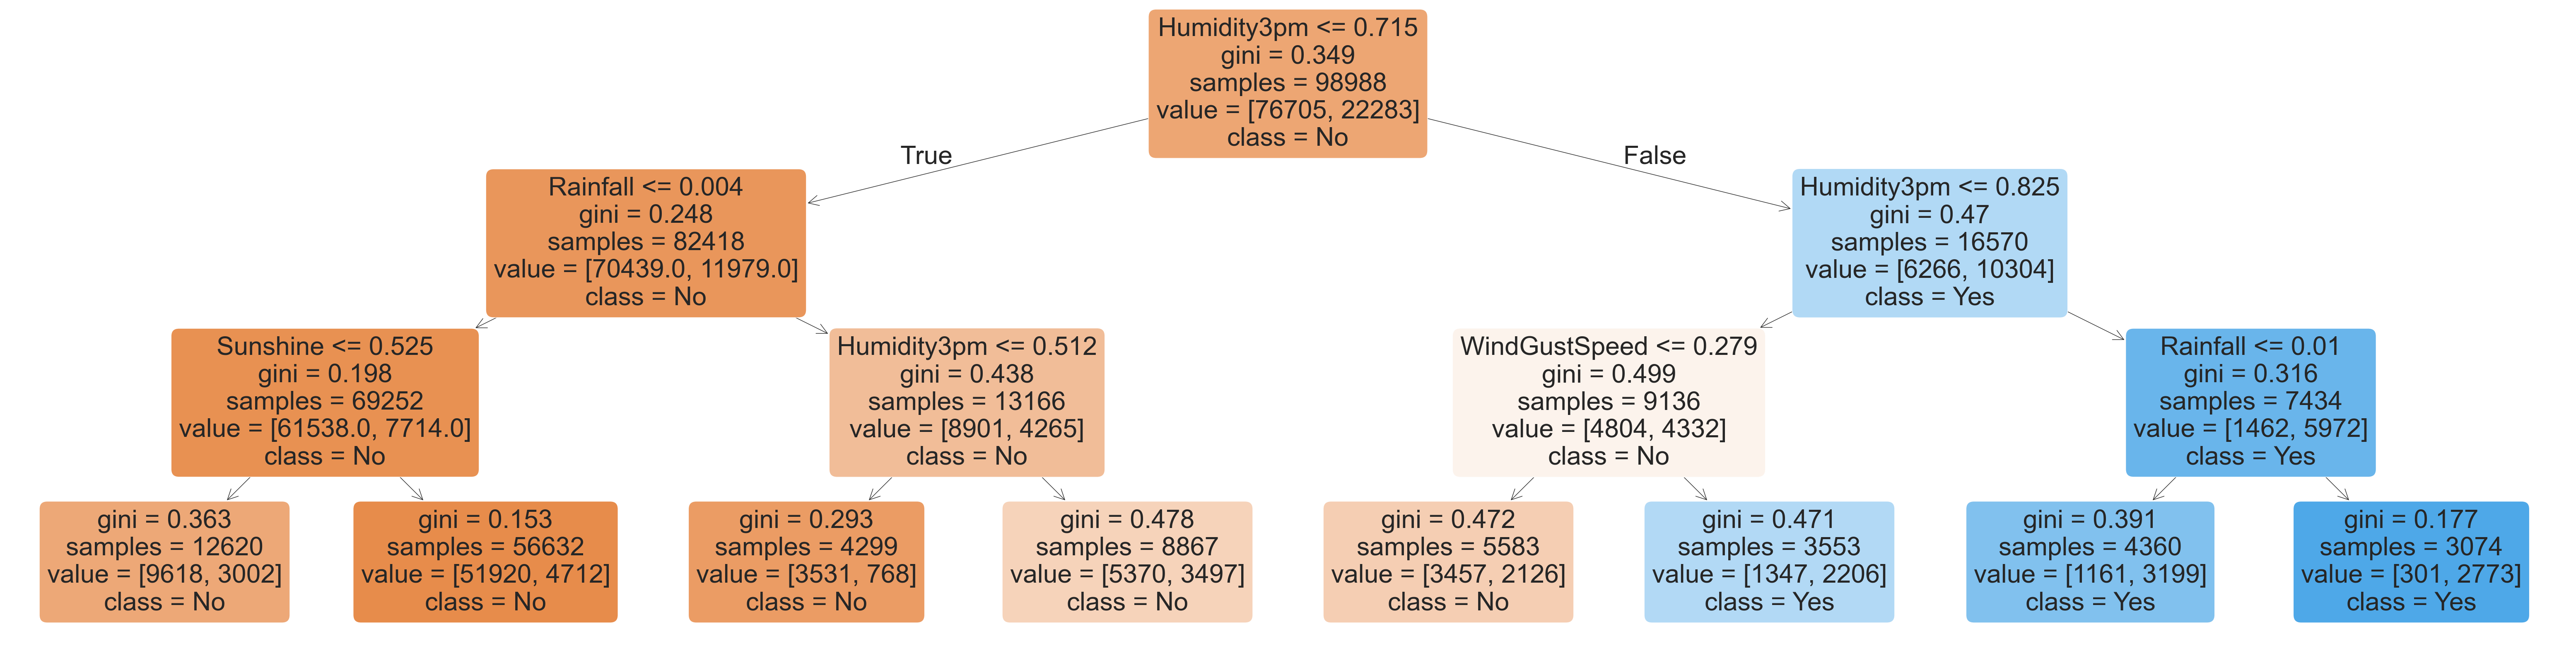

In [76]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [77]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [78]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: total: 1min 3s
Wall time: 1min 9s


In [79]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.184315,0.177935
1,2,0.179547,0.172712
2,3,0.170869,0.166560
3,4,0.165707,0.164355
4,5,0.160676,0.159074
5,6,0.156271,0.157275
6,7,0.153312,0.154605
7,8,0.147806,0.158029
8,9,0.140906,0.156578
9,10,0.132945,0.157333


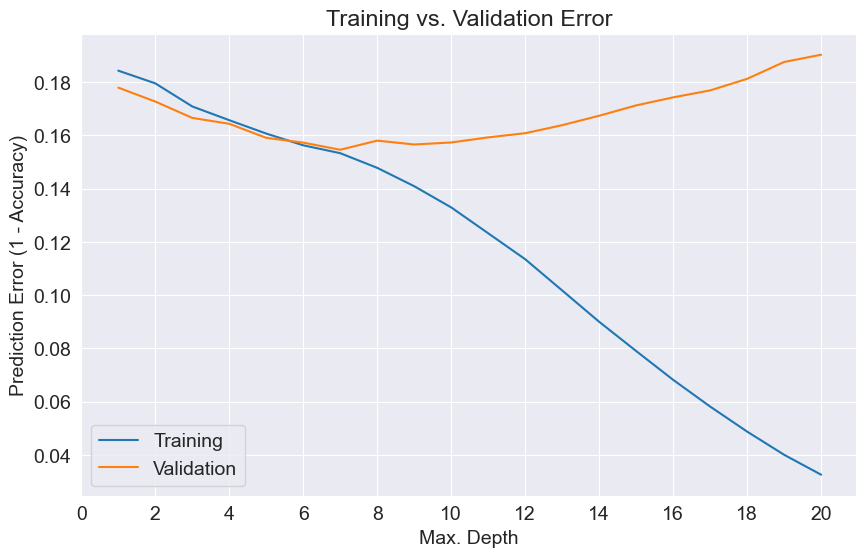

In [80]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">


You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [99]:
model = DecisionTreeClassifier(max_leaf_nodes = 128,max_depth=7, random_state=42)

In [100]:
model.fit(X_train, train_targets)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",128
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current nod

In [101]:
accuracy_score(model.predict(X_val),val_targets)*100

84.53949277465034